# 基于pytorch的BERT复现

In [ ]:
import d2l_torch as d2l

In [ ]:
cd /content/drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


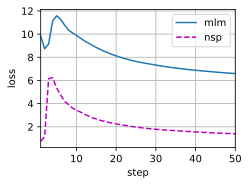

In [ ]:
import torch
from torch import nn
from torch.optim import Adam

def get_tokens_and_segments(token_a, token_b=None):
    tokens = ['<cls>'] + token_a + ['<sep>']
    segments = [0] * (len(token_a) + 2)
    if token_b is not None:
        tokens += token_b + ['<sep>']
        segments += [1] * (len(token_b) + 1)
    return tokens, segments


class BertEncoder(nn.Module):
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout,
                 max_len=1000, key_size=768, query_size=768, value_size=768,
                 **kwargs) -> None:
        super(BertEncoder, self).__init__()
        self.tokens_embed = nn.Embedding(vocab_size, num_hiddens)
        self.segments_embed = nn.Embedding(2, num_hiddens)
        self.blk = nn.Sequential()
        for i in range(num_layers):
            self.blk.add_module(f"{i}", d2l.EncoderBlock(
                key_size, query_size, value_size, num_hiddens, norm_shape,
                ffn_num_input, ffn_num_hiddens, num_heads, dropout)
                                )
        # 使用可学习的位置函数
        self.pos_embed = nn.Parameter(torch.randn((1, max_len, num_hiddens)))

    def forward(self, tokens, segments, valid_len):
        X = self.tokens_embed(tokens) + self.segments_embed(segments)
        X = X + self.pos_embed.data[:, :X.shape[1], :]
        for blk in self.blk:
            X = blk(X, valid_len)
        return X

# 随机遮住序列的某个位置，使用MaskLM预测该位置的词元
class MaskLM(nn.Module):
    def __init__(self, vocab_size, num_hiddens, num_input=768) -> None:
        super(MaskLM, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(num_input, num_hiddens),
            nn.ReLU(),
            nn.LayerNorm(num_hiddens),
            nn.Linear(num_hiddens, vocab_size)
        )

    def forward(self, X, preds_position):
        num_preds = preds_position.shape[1]
        batch_size = X.shape[0]
        batch_idx = torch.arange(0, batch_size)
        batch_idx = torch.repeat_interleave(batch_idx, num_preds).reshape(batch_size, num_preds)
        # 拿出待预测的那一部分X
        mask_X = X[batch_idx, preds_position]
        return self.mlp(mask_X)


# 预测下一个句子
class NextSentencePred(nn.Module):
    def __init__(self, num_input) -> None:
        super(NextSentencePred, self).__init__()
        self.linear = nn.Linear(num_input, 2)

    def forward(self, X):
        return self.linear(X)

class BertModel(nn.Module):

    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout,
                 max_len=1000, key_size=768, query_size=768, value_size=768,
                 hid_in_features=768, mlm_in_features=768,
                 nsp_in_features=768) -> None:
        super(BertModel, self).__init__()
        self.encoder = BertEncoder(vocab_size, num_hiddens, num_layers, norm_shape, ffn_num_input,
                                   ffn_num_hiddens, num_heads, dropout)
        self.hidden = nn.Sequential(nn.Linear(hid_in_features, num_hiddens),
                                    nn.Tanh())
        self.mlm = MaskLM(vocab_size, num_hiddens)
        self.nsp = NextSentencePred(nsp_in_features)

    def forward(self, tokens, segments, valid_lens=None,
                pred_positions=None):
        encoded_X = self.encoder(tokens, segments, valid_lens)
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None
        nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :]))
        return encoded_X, mlm_Y_hat, nsp_Y_hat


def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    net = net.to(devices)
    optim=Adam(net.parameters(),lr=0.1)
    loss=nn.CrossEntropyLoss()
    loss=loss.to(devices)
    step=0
    metric = d2l.Accumulator(4)
    animator = d2l.Animator(xlabel='step', ylabel='loss',
                            xlim=[1, num_steps], legend=['mlm', 'nsp'])
    while (True):
        for tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X, mlm_Y, nsp_y in train_iter:
            tokens_X = tokens_X.to(devices)
            segments_X = segments_X.to(devices)
            valid_lens_x = valid_lens_x.to(devices)
            pred_positions_X = pred_positions_X.to(devices)
            mlm_weights_X = mlm_weights_X.to(devices)
            mlm_Y, nsp_y = mlm_Y.to(devices), nsp_y.to(devices)

            optim.zero_grad()
            mlm_l, nsp_l,ls=d2l._get_batch_loss_bert(net,loss,vocab_size,tokens_X,segments_X,valid_lens_x,pred_positions_X,mlm_weights_X,mlm_Y,nsp_y)
            ls.backward()
            optim.step()

            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            animator.add(step + 1,
                         (metric[0] / metric[3], metric[1] / metric[3]))
            step+=1
            if step==num_steps:
                break

        if step == num_steps:
            break


batch_size, max_len = 512, 64
train_iter, vocab = d2l.load_data_wiki(batch_size, max_len)
net = d2l.BERTModel(len(vocab), num_hiddens=128, norm_shape=[128],
                    ffn_num_input=128, ffn_num_hiddens=256, num_heads=2,
                    num_layers=2, dropout=0.2, key_size=128, query_size=128,
                    value_size=128, hid_in_features=128, mlm_in_features=128,
                    nsp_in_features=128)
devices = d2l.try_all_gpus()[0]
print(devices)
loss = nn.CrossEntropyLoss()
train_bert(train_iter, net, loss, len(vocab), devices, 50)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

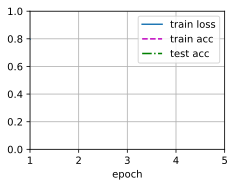

In [ ]:
import json
import multiprocessing
from random import random
import torch
import os
from torch.utils import data
from torch import nn

d2l.DATA_HUB['bert.base'] = (d2l.DATA_URL + 'bert.base.torch.zip',
                             '225d66f04cae318b841a13d32af3acc165f253ac')
d2l.DATA_HUB['bert.small'] = (d2l.DATA_URL + 'bert.small.torch.zip',
                              'c72329e68a732bef0452e4b96a1c341c8910f81f')
def load_pretrained_model(pretrained_model, num_hiddens, ffn_num_hiddens,
                          num_heads, num_layers, dropout, max_len, devices):
    data_dir = d2l.download_extract(pretrained_model)
    # 定义空词表以加载预定义词表
    vocab = d2l.Vocab()
    vocab.idx_to_token = json.load(open(os.path.join(data_dir,
        'vocab.json')))
    vocab.token_to_idx = {token: idx for idx, token in enumerate(
        vocab.idx_to_token)}
    bert = d2l.BERTModel(len(vocab), num_hiddens, norm_shape=[256],
                         ffn_num_input=256, ffn_num_hiddens=ffn_num_hiddens,
                         num_heads=4, num_layers=2, dropout=0.2,
                         max_len=max_len, key_size=256, query_size=256,
                         value_size=256, hid_in_features=256,
                         mlm_in_features=256, nsp_in_features=256)
    # 加载预训练BERT参数
    bert.load_state_dict(torch.load(os.path.join(data_dir,
                                                 'pretrained.params')))
    return bert, vocab


class SNLIBERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len, vocab=None):
        all_premise_hypothesis_tokens = [[
            p_tokens, h_tokens] for p_tokens, h_tokens in zip(
            *[d2l.tokenize([s.lower() for s in sentences])
              for sentences in dataset[:2]])]

        self.labels = torch.tensor(dataset[2])
        self.vocab = vocab
        self.max_len = max_len
        (self.all_token_ids, self.all_segments,
         self.valid_lens) = self._preprocess(all_premise_hypothesis_tokens)
        print('read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, all_premise_hypothesis_tokens):
        pool = multiprocessing.Pool(1)  # 使用4个进程
        out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)
        all_token_ids = [
            token_ids for token_ids, segments, valid_len in out]
        all_segments = [segments for token_ids, segments, valid_len in out]
        valid_lens = [valid_len for token_ids, segments, valid_len in out]
        return (torch.tensor(all_token_ids, dtype=torch.long),
                torch.tensor(all_segments, dtype=torch.long),
                torch.tensor(valid_lens))

    def _mp_worker(self, premise_hypothesis_tokens):
        p_tokens, h_tokens = premise_hypothesis_tokens
        self._truncate_pair_of_tokens(p_tokens, h_tokens)
        tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] \
                             * (self.max_len - len(tokens))
        segments = segments + [0] * (self.max_len - len(segments))
        valid_len = len(tokens)
        return token_ids, segments, valid_len

    def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
        # 为BERT输入中的'<CLS>'、'<SEP>'和'<SEP>'词元保留位置
        while len(p_tokens) + len(h_tokens) > self.max_len - 3:
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx]), self.labels[idx]

    def __len__(self):
        return len(self.all_token_ids)
class BERTClassifier(nn.Module):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        self.encoder = bert.encoder
        self.hidden = bert.hidden
        self.output = nn.Linear(256, 3)

    def forward(self, inputs):
        tokens_X, segments_X, valid_lens_x = inputs
        encoded_X = self.encoder(tokens_X, segments_X, valid_lens_x)
        return self.output(self.hidden(encoded_X[:, 0, :]))

batch_size, max_len, num_workers = 512, 128, 1
devices = d2l.try_all_gpus()
bert, vocab = load_pretrained_model(
    'bert.small', num_hiddens=256, ffn_num_hiddens=512, num_heads=4,
    num_layers=2, dropout=0.1, max_len=512, devices=devices)

data_dir = d2l.download_extract('SNLI')
train_set = SNLIBERTDataset(d2l.read_snli(data_dir, True), max_len, vocab)
test_set = SNLIBERTDataset(d2l.read_snli(data_dir, False), max_len, vocab)
train_iter = data.DataLoader(train_set, batch_size, shuffle=True,
                                   num_workers=num_workers)
test_iter = data.DataLoader(test_set, batch_size,
                                  num_workers=num_workers)

net=BERTClassifier(bert)
lr, num_epochs = 1e-4, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
    devices)

# BERT for classification

In [7]:
pip install torch transformers datasets

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [1]:
pip install pyarrow==11.0.0 datasets==2.12.0

In [25]:
import torch
import torch.nn.functional as F
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import load_dataset

# 加载数据集
# dataset = load_dataset('imdb')

# 加载预训练模型和分词器
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

# 获取模型的配置
print(model.config)

# 将模型置于评估模式
model.eval()

# 样本输入文本
input_text = "The movie was absolutely fantastic."

# 对输入文本进行分词
inputs = tokenizer(input_text, return_tensors="pt")
print(inputs)
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']

# 将 input_ids 转换为 float，并启用梯度计算
input_ids = input_ids.float().clone().detach().requires_grad_(True)
# 获取模型的嵌入层
embedding_layer = model.bert.embeddings.word_embeddings

# 获取输入的嵌入表示
input_embeddings = embedding_layer(input_ids.long())  # 将 input_ids 转回 long 类型以获取嵌入表示

# 前向传播计算预测结果
outputs = model(inputs_embeds=input_embeddings, attention_mask=attention_mask)
logits = outputs.logits
predicted_class = torch.argmax(logits, dim=1).item()


# 计算损失
label = torch.tensor([predicted_class]).to(logits.device)
loss = F.cross_entropy(logits, label)

# 反向传播计算梯度
model.zero_grad()
loss.backward()

# 获取输入文本的梯度
input_grad = input_ids.grad

# 找到最重要的 token
important_token_id = torch.argmax(input_grad.abs()).item()
important_token = tokenizer.convert_ids_to_tokens(input_ids[0][important_token_id])

# 生成对抗样本，通过翻转最重要的 token
def generate_adversarial_sample(input_ids, important_token_id, new_token_id):
    adversarial_input_ids = input_ids.clone()
    adversarial_input_ids[0][important_token_id] = new_token_id
    return adversarial_input_ids

# 查找 vocab 中的所有 token
vocab = tokenizer.get_vocab()

# 尝试翻转重要的 token
for new_token in vocab.keys():
    new_token_id = vocab[new_token]
    if new_token_id != input_ids[0][important_token_id]:
        adversarial_input_ids = generate_adversarial_sample(input_ids, important_token_id, new_token_id)
        outputs = model(adversarial_input_ids, attention_mask=attention_mask)
        new_predicted_class = torch.argmax(outputs.logits, dim=1).item()
        if new_predicted_class != predicted_class:
            adversarial_text = tokenizer.decode(adversarial_input_ids[0], skip_special_tokens=True)
            print(f"Original text: {input_text}")
            print(f"Predicted class: {predicted_class}")
            print(f"Adversarial text: {adversarial_text}")
            print(f"New predicted class: {new_predicted_class}")
            break


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

{'input_ids': tensor([[  101,  1996,  3185,  2001,  7078, 10392,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}


AttributeError: 'NoneType' object has no attribute 'abs'

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import reuters
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import numpy as np

# 加载数据
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

# 数据预处理
tokenizer = Tokenizer(num_words=10000)
x_train = tokenizer.sequences_to_matrix(train_data, mode='binary')
x_test = tokenizer.sequences_to_matrix(test_data, mode='binary')

# 将标签进行one-hot编码
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

# 构建模型
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(10000,)))
model.add(Dropout(0.5))
model.add(Dense(46, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

# 训练模型
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=10,
                    verbose=1,
                    validation_split=0.2)

# 评估模型
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# 预测示例
sample_news = ["The stock market crashed today due to unforeseen circumstances."]
sample_sequences = tokenizer.texts_to_sequences(sample_news)
sample_matrix = tokenizer.sequences_to_matrix(sample_sequences, mode='binary')
predicted_class = np.argmax(model.predict(sample_matrix), axis=-1)

print("Predicted class:", predicted_class)


2110848/2110848 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               5120512   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 46)                23598     
                                                                 
Total params: 5144110 (19.62 MB)
Trainable params: 5144110 (19.62 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
225/225 [==============================] - 6s 25ms/step - loss: 1.3379 - accuracy: 0.7144 - val_loss: 0.8870 - val_accuracy: 0.8147
Epoch 2/10
225/225 [==============================] - 5s 23ms/step - loss: